In [1]:
#from comet_ml import Experiment
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import chi2 
from sklearn.feature_selection import f_classif 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import preprocessing
from statistics import mean
import time
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from math import log

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/countries-of-the-world/countries of the world.csv
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv')
df_train.shape


(386803, 17)

In [3]:
df_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv')
df_test.shape

(128935, 16)

In [4]:
submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv')

In [5]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

#hotels = pd.concat([df_test, df_train], ignore_index=False, sort=False) # объединяем
hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
display(hotels.shape)

/tmp/ipykernel_32/374948781.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


(515738, 18)

In [6]:
print(f"Duplicates found: {hotels[hotels.duplicated()].shape[0]}")
print(f"DataFrame shape before deduplication: {hotels.shape}")

Duplicates found: 336
DataFrame shape before deduplication: (515738, 18)


In [7]:
# countries data set downloaded from https://www.kaggle.com/datasets/fernandol/countries-of-the-world
countries = pd.read_csv('/kaggle/input/countries-of-the-world/countries of the world.csv', index_col=None)

countries['Country'] = countries['Country'].apply(lambda x: x.strip().lower())

countries = countries.loc[:,['Country', 'Pop. Density (per sq. mi.)', 'Net migration', 'Infant mortality (per 1000 births)', 'GDP ($ per capita)', 'Deathrate', 'Birthrate', 'Literacy (%)']]

In [8]:
# преобразуем признаки национальности пользователя и адрес отеля в удобный формат
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: 0 if len(x.strip())==0 else x.strip().lower())
hotels['hotel_address'] = hotels['hotel_address'].apply(lambda x: x.strip().lower())

def get_region(str):
    """The function is designed for extracting hotel country/city data from address string
    Args:
        str (string): string containing hotel address
    Returns:
        tuple(tuple): hotel data in format (country, city) 
    """
    splitted = str.split(' ')
    try:
        for i in countries['Country'].values:
            if splitted[-1] == i:
                return (splitted[-1], splitted[-2])
            elif (splitted[-2] + ' ' + splitted[-1]) == i:
                return (splitted[-2] + ' ' + splitted[-1], splitted[-5])
    except Exception:
        return np.nan, np.nan        

# сформируем признаки страны и города отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: get_region(x)[0])
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: get_region(x)[1])

In [9]:
# проверим есть дата сет на пропуски 
hotels.isnull().mean()

hotel_address                                 0.000000
additional_number_of_scoring                  0.000000
review_date                                   0.000000
average_score                                 0.000000
hotel_name                                    0.000000
reviewer_nationality                          0.000000
negative_review                               0.000000
review_total_negative_word_counts             0.000000
total_number_of_reviews                       0.000000
positive_review                               0.000000
review_total_positive_word_counts             0.000000
total_number_of_reviews_reviewer_has_given    0.000000
tags                                          0.000000
days_since_review                             0.000000
lat                                           0.006337
lng                                           0.006337
sample                                        0.000000
reviewer_score                                0.000000
hotel_coun

In [10]:
# заполним пропущенные значения
hotels_missed = {       
'Austria Trend Hotel Schloss Wilhelminenberg Wien': [48.2195694, 16.2855921],
'City Hotel Deutschmeister': [48.2208519, 16.3640366],
'Cordial Theaterhotel Wien': [48.2095489, 16.3488884],
'Derag Livinghotel Kaiser Franz Joseph Vienna': [48.2458873, 16.339354],
'Fleming s Selection Hotel Wien City': [48.2094018, 16.3508707],
'Holiday Inn Paris Montmartre': [48.8889092, 2.3305781],
'Hotel Advance': [41.3940017, 2.1593084],
'Hotel Atlanta': [48.2204103, 16.3509477],
'Hotel City Central': [48.213587, 16.3773333],
'Hotel Daniel Vienna': [48.1888148, 16.3812044],
'Hotel Park Villa': [48.2338567, 16.3342528],
'Hotel Pension Baron am Schottentor': [48.2167996, 16.3573308],
'Maison Albar Hotel Paris Op ra Diamond': [48.8757282, 2.3206811],
'Mercure Paris Gare Montparnasse': [48.8377262, 2.3159061],
'NH Collection Barcelona Podium': [41.391548, 2.1753191],
'Renaissance Barcelona Hotel': [41.3926849, 2.1648227],
'Roomz Vienna': [48.2227607, 16.3909124]
}

for i in range(hotels.shape[0]):
    if np.isnan(hotels.loc[i, 'lat']):
        hotels.loc[i, 'lat'] = hotels_missed[hotels.loc[i, 'hotel_name']][0]
        hotels.loc[i, 'lng'] = hotels_missed[hotels.loc[i, 'hotel_name']][1]

In [11]:
hotels.isnull().mean()

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
tags                                          0.0
days_since_review                             0.0
lat                                           0.0
lng                                           0.0
sample                                        0.0
reviewer_score                                0.0
hotel_country                                 0.0
hotel_city                                    0.0


In [12]:
# добавим признак почтовый код отеля
# The structure of a postcode is two alphanumeric codes that show, first, the Post Town and, second, 
# a small group of addresses in that post town. 
# The first alphanumeric code (the Outward code or Outcode) has between two and four characters and the second (the Inward Code or Incode) 
# always has three characters.

def get_post_code(str):
    """The function is designed for extracting postcode data from hotel address string
    Args:
        str (string): string containing hotel address
    Returns:
        string(string): hotel's postcode 
    """
    splitted = str.split(' ')
    if splitted[-1] == 'netherlands' or splitted[-1] == 'austria':
        return(re.findall(r'^[a-zA-Z0-9_\s.]+(\d{4})+[a-zA-Z0-9_.\s]+$', str)[0])
    elif splitted[-1] == 'france' or splitted[-1] == 'spain' or splitted[-1] == 'italy':
        return(re.findall(r'^[a-zA-Z0-9_\s.]+(\d{5})+[a-zA-Z0-9_.\s]+$', str)[0])
    elif splitted[-1] == 'kingdom':
        #return get_ascII((splitted[-4]))  #+ ' ' + splitted[-3]
        return  splitted[-4]+ ' ' + splitted[-3] 

# добавим признак посткод отеля
hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_post_code)


In [13]:
# преобразуем тэги в удобный для обработки формат
hotels['tags'] = hotels['tags'].apply(lambda x: [y.strip(string.whitespace + string.punctuation).lower() for y in x.split(',')])  

# добавим признак количество тэгов
hotels['tags_cnt'] = hotels['tags'].apply(lambda x: len(x) if 'submitted from a mobile device' not in x else (len(x)-1))

# сформируем словарь тэгов, ключи которого - тэги, значения - список из числа упоминаний во всех отзывах, и частоты тэга
dict = {}
for t in hotels['tags']:
    for i in t:
        if i == 'submitted from a mobile device':
            continue
        if i not in dict:
            dict[i] = 1
        else:
            dict[i] += 1

dict_sum = sum(list(dict.values()))

tag_rate_dict = {v[0]:[v[1],v[1]/dict_sum] for v in sorted(dict.items(), key=lambda x: (-x[1], x[0]))}


def tag_rate(lst):
    """The function is designed for counting tag frequencies sum in user's tag list
    Args:
        lst (list): tag list
    Returns:
        number(float): tag frequencies sum (log)
    """
    res = 0
    for t in lst:
        if t != 'submitted from a mobile device':
            res += tag_rate_dict[t][1]
    return res #log(1/res)

# добавим признак частоты тэгов
hotels['tags_rate'] = hotels['tags'].apply(tag_rate) 

In [14]:
hotels.loc[:3,['tags','tags_cnt']]

,tags,tags_cnt
0,"[leisure trip, couple, double room, stayed 2 n...",4
1,"[leisure trip, group, triple room, stayed 1 ni...",4
2,"[business trip, solo traveler, twin room, stay...",4
3,"[leisure trip, couple, ambassador junior suite...",4


In [15]:
def get_tag_data(lst):
    """The function is designed for getting useful data from tags
    Args:
        lst (list): tag list
    Returns:
        dict(dictionary): dictionary containing extracted data from tags
    """    
    dict ={'nights':1, 'customer_type':'solo', 'room_type': 'single', 'room_class':'standard'}
    lst1 = ['solo', 'couple', 'group', 'family']
    lst2 = ['standard', 'classic',  'basic']
    lst3 = ['deluxe', 'superior']
    lst4 = ['single', 'double', 'triple', 'quad', 'queen', 'king', 'twin', 'studio', 'suite', 'apartments', 'connecting',
    'cabana', 'adjoining']
    splitted = ' '.join(lst).lower().replace(',','').split()
    for item in splitted:
        if item in lst1:
            dict['customer_type'] = item
        if item in lst2:
            dict['room_class'] = 'standard'
        if item in lst3:
            dict['room_class'] = 'superior'
        if item in lst4:
            dict['room_type'] = item
    for t,g in enumerate(splitted):
        if 'night' in g:
            dict['nights'] = splitted[t-1]
    return dict

In [16]:
# добавим признаки на основании информации из тэгов
hotels['nights'] = hotels['tags'].apply(lambda x: int(get_tag_data(x)['nights']))
hotels['customer_type'] = hotels['tags'].apply(lambda x: get_tag_data(x)['customer_type'])
hotels['room_class'] = hotels['tags'].apply(lambda x: get_tag_data(x)['room_class'])
hotels['room_type'] = hotels['tags'].apply(lambda x: get_tag_data(x)['room_type'])


In [17]:
print(hotels['customer_type'].value_counts())
print(hotels['room_type'].value_counts())
print(hotels['room_class'].value_counts())

couple    251636
solo      110357
family     89399
group      64346
Name: customer_type, dtype: int64
double        212899
twin          134039
single         79760
king           30771
queen          28436
suite          16905
triple          9479
studio          3050
connecting       353
quad              36
adjoining          6
apartments         4
Name: room_type, dtype: int64
standard    364272
superior    151466
Name: room_class, dtype: int64


In [18]:
# сформируем список сообщений в отзывах, указывающих на то, что отрицательный отзыв не является отрицательным 
lst_not_neg = ['nothing', 'no negative', ' ', 'n a', 'na', 'nothing at all', 'none', 'nothing to dislike', 
               'not applicable', 'all good', 'nothing really', 'nil', 'nill', 'no complaints', 'nothing at all', 
               'absolutely nothing', 'no', 'everything was perfect', 'can t think of anything', 
               'everything was great', 'nothing to complain about', 'liked everything', 'non', 
               'everything was good', 'all was good', 'i liked everything', 'nothing all good', 
               'nothing everything was perfect', 'nothing it was perfect', 'there was nothing to dislike', 
               'nothing in particular', 'nothing everything was great', 'everything was fine', 
               'nothing comes to mind', 'there was nothing i didn t like', 'not a thing', 'nothing i didn t like', 
               'no complaints at all', 'we liked everything', 'no negatives', 'all ok', 'nothing to report', 
               'no thing', 'it was all good', 'loved everything', 'there was nothing we didn t like', 
               'nothing i can think of', 'nothing to say', 'no dislikes', 'no bad experience', 
               'nothing to mention', 'there was nothing not to like', 'nothing to complain', 'no issues', 
               'no comment', 'everything was ok', 'everything was excellent', 'no problems', 'nada', 
               'nothing we didn t like', 'nothing special', 'nothing bad to say'] 

# сформируем список сообщений в отзывах, указывающих на то, что положительный отзыв не является положительным
lst_not_pos = ['no positive', 'nothing', 'not much', 'not a lot']

# модифицируем признаки для более удобной работы
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.strip((string.whitespace + string.punctuation)).lower().replace((string.whitespace + string.punctuation),''))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip((string.whitespace + string.punctuation)).lower().replace((string.whitespace + string.punctuation),''))
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 'no positive' if len(x)==0 or x in lst_not_pos else x)
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 'no negative' if len(x)==0 or x in lst_not_neg else x)

# создаем признаки чистой длины отзыва, без пробелов
hotels['pos_rev_len'] = hotels['positive_review'].apply(lambda x: 0 if x == 'no positive' else len(x.replace(' ','')))
hotels['neg_rev_len'] = hotels['negative_review'].apply(lambda x: 0 if x == 'no negative' else len(x.replace(' ','')))

# модифицируем признаки количества слов, заменяя 0 те из них, которые обозначены как 'no positive' и 'no negative'
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x: 0 if x == 'no positive' else len(x.split()))
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x: 0 if x == 'no negative' else len(x.split()))

# создадим бинарные признаки для положительного и отрицательного отзывов
hotels['neg_rev'] = hotels['neg_rev_len'].apply(lambda x: 1 if x>0 else 0)
hotels['pos_rev'] = hotels['pos_rev_len'].apply(lambda x: 1 if x>0 else 0)

# создадим отдельный признак разницы бинарных 'pos_rev' и 'neg_rev'
hotels['true_pos'] = hotels['pos_rev'] - hotels['neg_rev']


In [19]:
# формируем листы экстремальных прилагательных, потенциально обозначающих супер недовольство или довольство клиента и
# придающих эмоциональную окраску отзывам
pos_lst_extra = ['too','very','absolutely', 'completely', 'totally', 'utterly', 'extremely', 'perfectly',  
                 'extraordinary', 'excellent', 'awesome', 'magic', 'great', 'outstanding', 'impressive', 'striking', 
                 'remarkable', 'praiseworthy', 'superb', 'superfine', 'super', 'invaluable', 'amazing','sensational', 
                 'terrific', 'marvelous', 'paramount', 'smashing', 'finest',  'magnificent', 'matchless', 'perfect', 
                 'superlative', 'unique', 'wonderful', 'exciting','majestic', 'hideous', 'astounding', 'best',
                 'delicious', 'fascinating', 'fantastic', 'excellent', 'gorgeous', 'hilarious', 'lovely', 'luxurious',
                'every thing','everything', 'every','incredible','incredibly','wonderfully']#better, really
neg_lst_extra = ['lousy', 'extremely', 'awful', 'crummy', 'atrocious', 'baneful', 'unwelcome', 'rude', 'torturous', 
                 'hurtful', 'disgraceful', 'direful', 'grievous', 'noxious', 'deleterious', 'raunchy', 'frustrating', 
                 'ill-boding', 'injurious', 'unlucky', 'unpolite', 'villainous', 'worst', 'apocalyptic', 'rough', 
                 'painful', 'oppressive', 'filthy', 'improperly', 'never', 'unhealthy', 'sinister', 'shoddy', 
                 'agonising', 'dreadful', 'ominous', 'perilous', 'discouraging', 'absolutely', 'worse', 
                 'inhospitable', 'perfectly', 'embarassing', 'impolite', 'ruinous', 'impolitely', 'very',
                 'fallacious', 'disparaging', 'damaging', 'sinful', 'endless', 'shameful', 'grim', 'pathetic', 
                 'evil', 'unsatisfactory', 'vicious', 'mournful', 'bothersome', 'vile', 'harrowing', 'utterly', 
                 'dire', 'horrible', 'regrettable', 'inappropriate', 'frustration', 'unacceptable', 'gutted', 
                 'menacing', 'disappointing', 'intolerable', 'extraordinary', 'too', 'terrible', 'excruciating', 
                 'harmful', 'depressing', 'slipshod', 'totally', 'improper', 'ill-fated', 'wicked', 'torturing', 
                 'extreme', 'unfriendly', 'miserable', 'godawful', 'unpleasant', 'deeply', 'wrenching', 
                 'nightmarish', 'hideous', 'hostile', 'unfortunate', 'furious', 'inadequate', 'laughable', 
                 'reprobate', 'disaster', 'detrimental', 'dangerous', 'troublesome', 'pernicious', 'completely', 
                 'terrifying', 'stinking', 'bleak', 'distressing', 'hopeless', 'disgusting', 
                 'morbid', 'threatening', 'doomy', 'worthless', 'disagreeable',
                 'every thing','everything','every','never','incredible','incredibly'] #ridiculous, really

def extreme_word_frequencies(df,feature, lst):
    """The function is designed for building extreme word frequencies dictionary for user reviews
    Args:
        df (DataFrame): source DataFrame
        feature (string): feature's name
    Returns:
        dictionary(dict): sorted dictionary  where key is word, value - a list of word's occurence count 
        and word's frequency 
    """
    dict = {}
    for item in df[feature]:
        for t in item.split():
            if t in lst:
                if t not in dict:
                    dict[t] = 1
                else:
                    dict[t] += 1
    dict_sum = sum(list(dict.values()))
    rate_dict = {v[0]:[v[1],v[1]/dict_sum] for v in sorted(dict.items(), key=lambda x: (-x[1], x[0]))}
    return rate_dict

def extreme_word_weight(str, dict):
    """The function is designed for counting extreme adjectives/words frequencies sum in user review
    Args:
        str (string): string containing user's input
        dict (dict): dictionary containing extreme adjectives/words frequencies
    Returns:
        tuple(tuple): word frequencies sum and word quantity in tuple format
    """
    res = 0
    cnt = 0
    for t in str.split():
        if t in dict:
            res += dict[t][1]
            cnt += 1
    return (res,cnt)

# формируем частотные словари для экстремальных слов в положительных и отрицательных отзывов
pos_extreme_dict =  extreme_word_frequencies(hotels, 'positive_review', pos_lst_extra)
neg_extreme_dict =  extreme_word_frequencies(hotels, 'negative_review', neg_lst_extra)

# формируем признаки количества экстремальных слов в отзыве
hotels['pos_rev_super_cnt'] = hotels['positive_review'].apply(lambda x: extreme_word_weight(x, pos_extreme_dict)[1])
hotels['neg_rev_super_cnt'] = hotels['negative_review'].apply(lambda x: extreme_word_weight(x, neg_extreme_dict)[1])

# формируем признаки частоты экстремальных слов в отзыве
hotels['pos_rev_super_rate'] = hotels['positive_review'].apply(lambda x: extreme_word_weight(x, pos_extreme_dict)[0])
hotels['neg_rev_super_rate'] = hotels['negative_review'].apply(lambda x: extreme_word_weight(x, neg_extreme_dict)[0])



In [20]:
# добавим признак количества отрицательных частиц в отрицательных отзывах
lst_no = ['dont', 'didnt', 'not', 'no', 'don', 'didn', 'doesn', 'doesnt', 'wasn', 'wasnt']

def count_no(str):
    """The function is designed for counting 'no' words in user review
    Args:
        str (string): string containing user's input
    Returns:
        number(int): quantity of 'no' words found
    """
    cnt = 0
    if str == 'no negative':
        return 0 #np.nan
    cnt = 0
    for w in str.lower().replace(',','').split():
        if w in lst_no:
            cnt += 1
    return cnt

hotels['no_cnt'] = hotels['negative_review'].apply(count_no) 

In [21]:
hotels['pos_rev_len_to_super_rate'] = hotels['pos_rev_len'] / hotels['pos_rev_super_rate']
hotels['neg_rev_len_to_super_rate'] = hotels['neg_rev_len'] / hotels['neg_rev_super_rate']

# создаем признаки отношение длины отзыва к количеству экстремальных описательных слов
hotels['neg_len_to_super_cnt'] = (hotels['neg_rev_len'] / hotels['neg_rev_super_cnt'])
hotels['pos_len_to_super_cnt'] = (hotels['pos_rev_len'] / hotels['pos_rev_super_cnt'])
hotels['neg_len_to_nocnt'] = (hotels['neg_rev_len'] / hotels['no_cnt'])

# заменим nan, образовавшиеся при создании признаков, на 0 
hotels.replace([np.inf, -np.inf], np.nan, inplace=True)
hotels['neg_rev_len_to_super_rate'] = hotels['neg_rev_len_to_super_rate'].apply(lambda x: 0 if np.isnan(x) else x)
hotels['pos_rev_len_to_super_rate'] = hotels['pos_rev_len_to_super_rate'].apply(lambda x: 0 if np.isnan(x) else x)
hotels['neg_len_to_super_cnt'] = hotels['neg_len_to_super_cnt'].apply(lambda x: 0 if np.isnan(x) else x)
hotels['pos_len_to_super_cnt'] = hotels['pos_len_to_super_cnt'].apply(lambda x: 0 if np.isnan(x) else x)
hotels['neg_len_to_nocnt'] = hotels['neg_len_to_nocnt'].apply(lambda x: 0 if np.isnan(x) else x)

In [22]:
# создаем признаки отношения длины отзыва к количеству слов в нем
hotels['neg_len_to_counts'] = hotels['neg_rev_len'] / hotels['review_total_negative_word_counts']
hotels['pos_len_to_counts'] = hotels['pos_rev_len'] / hotels['review_total_positive_word_counts']

# значения нан заменяем 0
hotels['neg_len_to_counts'] = hotels['neg_len_to_counts'].apply(lambda x: 0 if np.isnan(x) else x)
hotels['pos_len_to_counts'] = hotels['pos_len_to_counts'].apply(lambda x: 0 if np.isnan(x) else x)

In [23]:
def get_word_fcy(df, feature, word_len=1):
    """The function is designed for creating word frequencies dictionary for a specified feature
    Args:
        df (DataFrame): source DataFrame
        feature (string): feature's name
        word_len (int): word length filter 
    Returns:
        dictionary(dict): sorted dictionary  where key is word, value - a list of word's occurence count 
        and word's frequency 
    """
    
    short_words = ['the', 'was','to','and','in','of','for','it','we','is','on','were','at','had',
                   'have','be','as','they','you','so','my','our','are','or',
                   'if','an','a','us','me','by', 've', 'am', 'do','has','he','its','them',
                   'then','when','this','from','there','that','where']
    dict = {}
    for k in df[feature]:
        for t in k.split():
            if len(t) > word_len  and t not in short_words:
                if t not in dict:
                    dict[str(t)] = 1
                else:
                    dict[str(t)] += 1
    dict_sum = sum(list(dict.values()))
    feature_rate_dict = {v[0]:[v[1],v[1]/dict_sum] for v in sorted(dict.items(), key=lambda x: (-x[1], x[0]))}
    return feature_rate_dict


def review_words_weight(str, dict, word_len=2): 
    """The function is designed to sum up word frequencies in a string
    Args:
        str (string): string containing user's input
        dict (dict): dictionary containing feature word frequencies
        word_len (int): word length filter 
    Returns:
        number(float): word frequencies sum
    """
    
    lst = ['no positive', 'no negative']
    res = 0
    if str in lst:
        return 0 #np.nan
    for t in str.split():
        if len(t) > word_len and t in dict:
            res += dict[t][1]
    return res

In [24]:
# добавим признак относительной ошибки пользователя
hotels['user_coef'] = (hotels['reviewer_score'] - hotels['average_score']) / hotels['average_score']

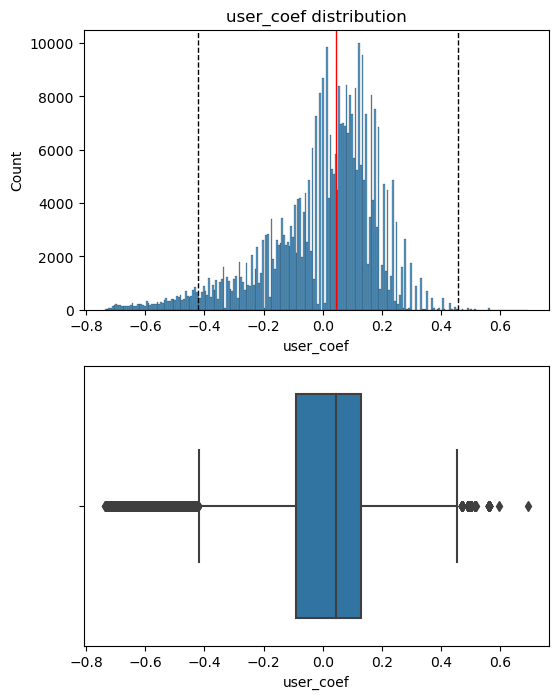

In [25]:
# визуализируем распределение относительной ошибки пользователя (user_coef)
f,a = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

hist = sns.histplot(hotels[hotels['sample'] == 1], x='user_coef', ax=a[0])
box = sns.boxplot(hotels[hotels['sample'] == 1], x='user_coef', ax=a[1], orient='h')

hist.set_title('user_coef distribution')
u_coef = hotels[hotels['sample'] == 1]['user_coef']
hist.axvline(u_coef.median(), color='r', lw=1)
hist.axvline(u_coef.quantile(0.75) + 1.5 * (u_coef.quantile(0.75)-u_coef.quantile(0.25)), color='k', ls='--', lw=1) 
hist.axvline(u_coef.quantile(0.25) - 1.5 * (u_coef.quantile(0.75)-u_coef.quantile(0.25)), color='k', ls='--', lw=1);

In [26]:
# оценим количество потенциальных выбросов по user_coef (relative error)
def outliers_iqr(data, feature):
    """The function is designed to define outliers for a specified feature according the IQR method
    Args:
        data (DataFrame): source DataFrame
        feature (string): name of the feature to analyse
    Returns:
        outliers, cleaned (DataFrame): outliers - DataFrame containing outliers, cleaned - source
        DF without outliers
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

out, df = outliers_iqr(hotels[hotels['sample']==1], 'user_coef')
print(f'DF shape: {hotels.shape}')
print(f'Число потенциальных выбросов user_coef по методу Тьюки: {out.shape[0]}')


DF shape: (515738, 45)
Число потенциальных выбросов user_coef по методу Тьюки: 15090


Количество потенциальных выбросов достаточно велико. Их удаление может отрицательно сказаться на точности прогнозирования. Попробуем отсеять выбросы только при формировании обучающих словарей, не удаляя из тренировочного сета

In [27]:
print(hotels.shape)

# фильтр по пустым отзывам (без положительного и отрицательного одновременно)
hotels = hotels[~((hotels['neg_rev']==0) & (hotels['pos_rev']==0) & (hotels['sample']==1))]

print(hotels.shape)

(515738, 45)
(515385, 45)


In [28]:
%%time

# сформируем маски для обучающих словарей
m1 = (hotels['neg_rev'] == 1) & (abs(hotels['user_coef']) <= 0.4) & (hotels['sample'] == 1) & (hotels['neg_rev_super_cnt']==0)
m2 = (hotels['pos_rev'] == 1) & (abs(hotels['user_coef']) <= 0.4) & (hotels['sample'] == 1) & (hotels['pos_rev_super_cnt']==0)
m3 = (hotels['neg_rev'] == 1) & (abs(hotels['user_coef']) <= 0.4) & (hotels['sample'] == 1) & (hotels['neg_rev_super_cnt']>0)
m4 = (hotels['pos_rev'] == 1) & (abs(hotels['user_coef']) <= 0.4) & (hotels['sample'] == 1) & (hotels['pos_rev_super_cnt']>0)
m5 = (hotels['neg_rev'] == 1) & (abs(hotels['user_coef']) > 0.4) & (hotels['sample'] == 1) & (hotels['neg_rev_super_cnt']==0)
m6 = (hotels['pos_rev'] == 1) & (abs(hotels['user_coef']) > 0.4) & (hotels['sample'] == 1) & (hotels['pos_rev_super_cnt']==0)
m7 = (hotels['neg_rev'] == 1) & (abs(hotels['user_coef']) > 0.4) & (hotels['sample'] == 1) & (hotels['neg_rev_super_cnt']>0)
m8 = (hotels['pos_rev'] == 1) & (abs(hotels['user_coef']) > 0.4) & (hotels['sample'] == 1) & (hotels['pos_rev_super_cnt']>0)
                                   
# формируем обучающие словари, которые в теории должны помочь модели прогнозировать target с учетом суммарных 
# частот используемых для отзывов слов
dict1 = get_word_fcy(hotels[(hotels['reviewer_score']<4) & m1], 'negative_review')
dict2 = get_word_fcy(hotels[(hotels['reviewer_score']>=4) & (hotels['reviewer_score']<5) & m1], 'negative_review')
dict3 = get_word_fcy(hotels[(hotels['reviewer_score']>=5) & (hotels['reviewer_score']<6) & m1], 'negative_review')
dict4 = get_word_fcy(hotels[(hotels['reviewer_score']>=6) & (hotels['reviewer_score']<7) & m1], 'negative_review')
dict5 = get_word_fcy(hotels[(hotels['reviewer_score']>=7) & (hotels['reviewer_score']<8) & m1], 'negative_review')
dict6 = get_word_fcy(hotels[(hotels['reviewer_score']>=8) & (hotels['reviewer_score']<9) & m1], 'negative_review')
dict7 = get_word_fcy(hotels[(hotels['reviewer_score']>=9) & m1], 'negative_review')
dict8 = get_word_fcy(hotels[(hotels['reviewer_score']<4) & m2], 'positive_review')
dict9 = get_word_fcy(hotels[(hotels['reviewer_score']>=4) & (hotels['reviewer_score']<5) & m2], 'positive_review')
dict10 = get_word_fcy(hotels[(hotels['reviewer_score']>=5) & (hotels['reviewer_score']<6) & m2], 'positive_review')
dict11 = get_word_fcy(hotels[(hotels['reviewer_score']>=6) & (hotels['reviewer_score']<7) & m2], 'positive_review')
dict12 = get_word_fcy(hotels[(hotels['reviewer_score']>=7) & (hotels['reviewer_score']<8) & m2], 'positive_review')
dict13 = get_word_fcy(hotels[(hotels['reviewer_score']>=8) & (hotels['reviewer_score']<9) & m2], 'positive_review')
dict14 = get_word_fcy(hotels[(hotels['reviewer_score']>=9) & m2], 'positive_review')
dict15 = get_word_fcy(hotels[(hotels['reviewer_score']<4) & m3], 'negative_review')
dict16 = get_word_fcy(hotels[(hotels['reviewer_score']>=4) & (hotels['reviewer_score']<5) & m3], 'negative_review')
dict17 = get_word_fcy(hotels[(hotels['reviewer_score']>=5) & (hotels['reviewer_score']<6) & m3], 'negative_review')
dict18 = get_word_fcy(hotels[(hotels['reviewer_score']>=6) & (hotels['reviewer_score']<7) & m3], 'negative_review')
dict19 = get_word_fcy(hotels[(hotels['reviewer_score']>=7) & (hotels['reviewer_score']<8) & m3], 'negative_review')
dict20 = get_word_fcy(hotels[(hotels['reviewer_score']>=8) & (hotels['reviewer_score']<9) & m3], 'negative_review')
dict21 = get_word_fcy(hotels[(hotels['reviewer_score']>=9) & m3], 'negative_review')
dict22 = get_word_fcy(hotels[(hotels['reviewer_score']<4) & m4], 'positive_review')
dict23 = get_word_fcy(hotels[(hotels['reviewer_score']>=4) & (hotels['reviewer_score']<5) & m4], 'positive_review')
dict24 = get_word_fcy(hotels[(hotels['reviewer_score']>=5) & (hotels['reviewer_score']<6) & m4], 'positive_review')
dict25 = get_word_fcy(hotels[(hotels['reviewer_score']>=6) & (hotels['reviewer_score']<7) & m4], 'positive_review')
dict26 = get_word_fcy(hotels[(hotels['reviewer_score']>=7) & (hotels['reviewer_score']<8) & m4], 'positive_review')
dict27 = get_word_fcy(hotels[(hotels['reviewer_score']>=8) & (hotels['reviewer_score']<9) & m4], 'positive_review')
dict28 = get_word_fcy(hotels[(hotels['reviewer_score']>=9) & m4], 'positive_review')
dict29 = get_word_fcy(hotels[(hotels['reviewer_score']<4) & m5], 'negative_review')
dict30 = get_word_fcy(hotels[(hotels['reviewer_score']>=4) & (hotels['reviewer_score']<5) & m5], 'negative_review')
dict31 = get_word_fcy(hotels[(hotels['reviewer_score']>=5) & (hotels['reviewer_score']<6) & m5], 'negative_review')
dict32 = get_word_fcy(hotels[(hotels['reviewer_score']>=6) & (hotels['reviewer_score']<7) & m5], 'negative_review')
dict33 = get_word_fcy(hotels[(hotels['reviewer_score']>=7) & (hotels['reviewer_score']<8) & m5], 'negative_review')
dict34 = get_word_fcy(hotels[(hotels['reviewer_score']>=8) & (hotels['reviewer_score']<9) & m5], 'negative_review')
dict35 = get_word_fcy(hotels[(hotels['reviewer_score']>=9) & m5], 'negative_review')
dict36 = get_word_fcy(hotels[(hotels['reviewer_score']<4) & m6], 'positive_review')
dict37 = get_word_fcy(hotels[(hotels['reviewer_score']>=4) & (hotels['reviewer_score']<5) & m6], 'positive_review')
dict38 = get_word_fcy(hotels[(hotels['reviewer_score']>=5) & (hotels['reviewer_score']<6) & m6], 'positive_review')
dict39 = get_word_fcy(hotels[(hotels['reviewer_score']>=6) & (hotels['reviewer_score']<7) & m6], 'positive_review')
dict40 = get_word_fcy(hotels[(hotels['reviewer_score']>=7) & (hotels['reviewer_score']<8) & m6], 'positive_review')
dict41 = get_word_fcy(hotels[(hotels['reviewer_score']>=8) & (hotels['reviewer_score']<9) & m6], 'positive_review')
dict42 = get_word_fcy(hotels[(hotels['reviewer_score']>=9) & m6], 'positive_review')
dict43 = get_word_fcy(hotels[(hotels['reviewer_score']<4) & m7], 'negative_review')
dict44 = get_word_fcy(hotels[(hotels['reviewer_score']>=4) & (hotels['reviewer_score']<5) & m7], 'negative_review')
dict45 = get_word_fcy(hotels[(hotels['reviewer_score']>=5) & (hotels['reviewer_score']<6) & m7], 'negative_review')
dict46 = get_word_fcy(hotels[(hotels['reviewer_score']>=6) & (hotels['reviewer_score']<7) & m7], 'negative_review')
dict47 = get_word_fcy(hotels[(hotels['reviewer_score']>=7) & (hotels['reviewer_score']<8) & m7], 'negative_review')
dict48 = get_word_fcy(hotels[(hotels['reviewer_score']>=8) & (hotels['reviewer_score']<9) & m7], 'negative_review')
dict49 = get_word_fcy(hotels[(hotels['reviewer_score']>=9) & m7], 'negative_review')
dict50 = get_word_fcy(hotels[(hotels['reviewer_score']<4) & m8], 'positive_review')
dict51 = get_word_fcy(hotels[(hotels['reviewer_score']>=4) & (hotels['reviewer_score']<5) & m8], 'positive_review')
dict52 = get_word_fcy(hotels[(hotels['reviewer_score']>=5) & (hotels['reviewer_score']<6) & m8], 'positive_review')
dict53 = get_word_fcy(hotels[(hotels['reviewer_score']>=6) & (hotels['reviewer_score']<7) & m8], 'positive_review')
dict54 = get_word_fcy(hotels[(hotels['reviewer_score']>=7) & (hotels['reviewer_score']<8) & m8], 'positive_review')
dict55 = get_word_fcy(hotels[(hotels['reviewer_score']>=8) & (hotels['reviewer_score']<9) & m8], 'positive_review')
dict56 = get_word_fcy(hotels[(hotels['reviewer_score']>=9) & m8], 'positive_review')



CPU times: user 12.7 s, sys: 45.8 ms, total: 12.7 s
Wall time: 12.7 s


In [29]:
%%time

# создаем признаки на основании сформированных словарей
hotels['rate1'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict1))
hotels['rate2'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict2))
hotels['rate3'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict3))
hotels['rate4'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict4))
hotels['rate5'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict5))
hotels['rate6'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict6))
hotels['rate7'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict7))
hotels['rate8'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict8))
hotels['rate9'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict9))
hotels['rate10'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict10))
hotels['rate11'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict11))
hotels['rate12'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict12))
hotels['rate13'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict13))
hotels['rate14'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict14))
hotels['rate15'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict15))
hotels['rate16'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict16))
hotels['rate17'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict17))
hotels['rate18'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict18))
hotels['rate19'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict19))
hotels['rate20'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict20))
hotels['rate21'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict21))
hotels['rate22'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict22))
hotels['rate23'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict23))
hotels['rate24'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict24))
hotels['rate25'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict25))
hotels['rate26'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict26))
hotels['rate27'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict27))
hotels['rate28'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict28))

hotels['rate29'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict29))
hotels['rate30'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict30))
hotels['rate31'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict31))
hotels['rate32'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict32))
hotels['rate33'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict33))
hotels['rate34'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict34))
hotels['rate35'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict35))
hotels['rate36'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict36))
hotels['rate37'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict37))
hotels['rate38'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict38))
hotels['rate39'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict39))
hotels['rate40'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict40))
hotels['rate41'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict41))
hotels['rate42'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict42))
hotels['rate43'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict43))
hotels['rate44'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict44))
hotels['rate45'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict45))
hotels['rate46'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict46))
hotels['rate47'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict47))
hotels['rate48'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict48))
hotels['rate49'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, dict49))
hotels['rate50'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict50))
hotels['rate51'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict51))
hotels['rate52'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict52))
hotels['rate53'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict53))
hotels['rate54'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict54))
hotels['rate55'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict55))
hotels['rate56'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, dict56))

CPU times: user 2min 17s, sys: 304 ms, total: 2min 18s
Wall time: 2min 18s


In [30]:
hotels['tags'] = hotels['tags'].apply(lambda x: ' '.join(x).lower()) 

# по такому же принципу сформируем словари для обучения по тэгам
pos_tag_dict1 = get_word_fcy(hotels[(hotels['reviewer_score']>9) & (hotels['sample']==1) & (hotels['true_pos']==1)], 'tags', word_len=0)
neg_tag_dict1 = get_word_fcy(hotels[(hotels['reviewer_score']<5) & (hotels['sample']==1) & (hotels['true_pos']==-1)], 'tags', word_len=0) 


# сформируем признаки, при этом анализируем отзывы, а подсчитываем частоты по словарям, сформированным по тэгам
hotels['pos_tag_rate1'] = hotels['positive_review'].apply(lambda x: review_words_weight(x, pos_tag_dict1,word_len=0))
hotels['neg_tag_rate1'] = hotels['negative_review'].apply(lambda x: review_words_weight(x, neg_tag_dict1,word_len=0))

In [31]:
# сформируем признаки на основании даты отзыва
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_quarter'] = hotels['review_date'].dt.quarter
hotels['review_halfyear'] = np.where(hotels['review_date'].dt.month.le(6), 1, 2)
hotels['review_year'] = hotels['review_date'].dt.year

In [32]:
hotels['review_couple_months'] = hotels['review_month'].astype('object')

ord_encod = ce.OrdinalEncoder(mapping=[{
    'col':'review_couple_months',
    'mapping':{1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5, 10:5, 11:6, 12:6}
    }])

hotels['review_couple_months'] = ord_encod.fit_transform(hotels[['review_couple_months']])

In [33]:
# создадим признак аналогичности страны отеля и пользователя
hotels['same_country'] = (hotels['reviewer_nationality'] == hotels['hotel_country'])

# сформируем признак отношения 'total_number_of_reviews' к 'additional_number_of_scoring'
hotels['totrev_to_addscore'] = hotels['total_number_of_reviews'] / hotels['additional_number_of_scoring']

In [34]:
# кодируем признаки типа object
ord_encoder = ce.OrdinalEncoder()
h = ord_encoder.fit_transform(hotels.loc[:,['room_type', 'room_class', 'customer_type','hotel_postcode', 'hotel_country' , 'hotel_city', 'reviewer_nationality', 'hotel_name']]) 
hotels = hotels.drop(['room_type', 'room_class', 'customer_type', 'hotel_postcode', 'hotel_country' , 'hotel_city', 'reviewer_nationality', 'hotel_name'], axis=1) 
hotels = pd.concat([hotels, h], axis=1)

In [35]:
# список неинформативных признаков
low_information_cols = [] 

# цикл по всем столбцам
for col in hotels.columns:
    # наибольшая относительная частота в признаке
    top_freq = hotels[col].value_counts(normalize=True).max()
    # доля уникальных значений от размера признака
    nunique_ratio = hotels[col].nunique() / hotels[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

tags_cnt: 96.82% одинаковых значений
rate32: 100.0% одинаковых значений
rate39: 100.0% одинаковых значений
rate46: 100.0% одинаковых значений
rate48: 100.0% одинаковых значений
rate53: 100.0% одинаковых значений


In [36]:
# удаляем не нужные признаки
hotels = hotels.drop(['review_date', 'hotel_address', 'negative_review', 'positive_review', 'tags','days_since_review'], axis=1)
hotels = hotels.drop(low_information_cols, axis=1)

In [37]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

display(test_data.shape)
display(train_data.shape)

(128935, 97)

(386450, 97)

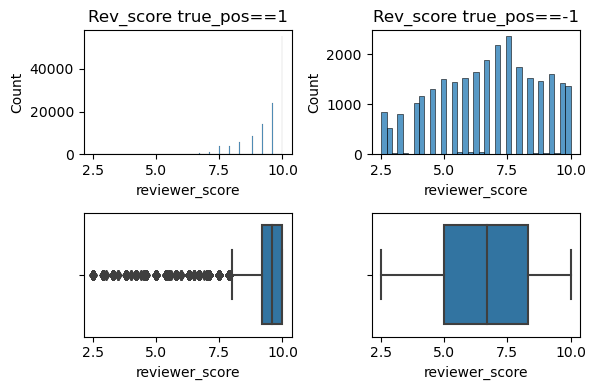

In [38]:
# перед созданием модели, попытаемся минимализировать абсурдные отзывы: чисто отрицательные с оценкой более 9 и 
# чисто положительные с оценкой менее 4. визуализация 1 abs(user_coef)>0
fig,axe = plt.subplots(nrows=2, ncols=2, figsize=(6,4))
sns.histplot(train_data[(train_data['true_pos'] ==1) & (abs(train_data['user_coef'])>0)], x='reviewer_score', ax=axe[0][0]).set_title('Rev_score true_pos==1')
sns.histplot(train_data[(train_data['true_pos'] ==-1) & (abs(train_data['user_coef'])>0)], x='reviewer_score', ax=axe[0][1]).set_title('Rev_score true_pos==-1')
sns.boxplot(train_data[(train_data['true_pos'] ==1) & (abs(train_data['user_coef'])>0)], x='reviewer_score', orient='h', ax=axe[1][0])
sns.boxplot(train_data[(train_data['true_pos'] ==-1) & (abs(train_data['user_coef'])>0)], x='reviewer_score', orient='h', ax=axe[1][1])
plt.tight_layout()

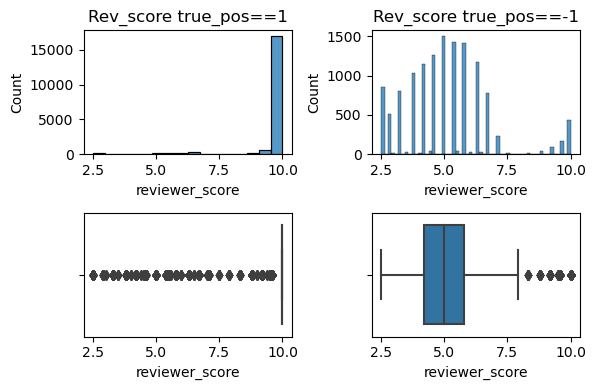

In [39]:
# перед созданием модели, попытаемся минимализировать абсурдные отзывы: отрицательные с оценкой более 9 и 
# положительные с оценкой менее 4. визуализация 2 abs(user_coef)>0.2
fig,axe = plt.subplots(nrows=2, ncols=2, figsize=(6,4))
sns.histplot(train_data[(train_data['true_pos'] ==1) & (abs(train_data['user_coef'])>0.2)], x='reviewer_score', ax=axe[0][0]).set_title('Rev_score true_pos==1')
sns.histplot(train_data[(train_data['true_pos'] ==-1) & (abs(train_data['user_coef'])>0.2)], x='reviewer_score', ax=axe[0][1]).set_title('Rev_score true_pos==-1')
sns.boxplot(train_data[(train_data['true_pos'] ==1) & (abs(train_data['user_coef'])>0.2)], x='reviewer_score', orient='h', ax=axe[1][0])
sns.boxplot(train_data[(train_data['true_pos'] ==-1) & (abs(train_data['user_coef'])>0.2)], x='reviewer_score', orient='h', ax=axe[1][1])
plt.tight_layout()

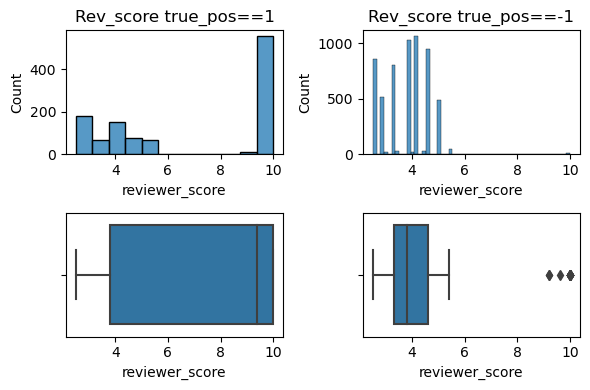

In [40]:
# перед созданием модели, попытаемся минимализировать абсурдные отзывы: отрицательные с оценкой более 9 и 
# положительные с оценкой менее 4. визуализация 3 abs(user_coef)>0.4
fig,axe = plt.subplots(nrows=2, ncols=2, figsize=(6,4))
sns.histplot(train_data[(train_data['true_pos'] ==1) & (abs(train_data['user_coef'])>0.4)], x='reviewer_score', ax=axe[0][0]).set_title('Rev_score true_pos==1')
sns.histplot(train_data[(train_data['true_pos'] ==-1) & (abs(train_data['user_coef'])>0.4)], x='reviewer_score', ax=axe[0][1]).set_title('Rev_score true_pos==-1')
sns.boxplot(train_data[(train_data['true_pos'] ==1) & (abs(train_data['user_coef'])>0.4)], x='reviewer_score', orient='h', ax=axe[1][0])
sns.boxplot(train_data[(train_data['true_pos'] ==-1) & (abs(train_data['user_coef'])>0.4)], x='reviewer_score', orient='h', ax=axe[1][1])
plt.tight_layout()

In [41]:
# отфильтруем и удалим отзывы с ненормальными оценками (чисто положительный <3, чисто отрицательный >9.9), 
# чтобы облегчить работу модели
print(train_data.shape)
train_data = train_data[~((train_data['true_pos'] ==1) & (train_data['reviewer_score'] < 3))]
print(train_data.shape)
train_data = train_data[~((train_data['true_pos'] ==-1) & (train_data['reviewer_score'] > 9.9))]
print(train_data.shape)

(386450, 97)
(386271, 97)
(384902, 97)


In [42]:
# удалим дубликаты в данных
print(f"Duplicates found: {train_data[train_data.duplicated()].shape[0]}")
print(f"DataFrame shape before deduplication: {train_data.shape}")
train_data = train_data.drop_duplicates()
print(f"DataFrame shape after deduplication: {train_data.shape}")

Duplicates found: 308
DataFrame shape before deduplication: (384902, 97)
DataFrame shape after deduplication: (384594, 97)


In [43]:
#r_scaler = preprocessing.RobustScaler()

#train_data.loc[:,n_cols] = r_scaler.fit_transform(train_data.loc[:,n_cols])

In [44]:
# создадим матрицу корреляции и на основании ее отберем признаки, удовлетворяющие условию
corr_matrix = train_data.corr(method='spearman')

q = corr_matrix[(abs(corr_matrix)>0.07) & (abs(corr_matrix)<0.89)]['reviewer_score'].sort_values()#

best_fea = list(q[~q.isna()].index)

print(f"best features according to correlation limits 0.07-0.89: {len(best_fea)}")

best features according to correlation limits 0.07-0.89: 74


In [45]:
# выделим таргет
y = train_data.reviewer_score.values            

# выделим тренировочный сет. удалим также признак 'user_coef' ввиду сильной корреляции с таргет. чтобы избежать 
# перетренировки модели
X = train_data.drop(['reviewer_score'], axis=1)

# ограничим сет отобранными признаками
X = X.loc[:, best_fea]

In [46]:
# выбираем лучшие признаки для тренировки

#select = SelectKBest(score_func=f_regression, k=73)
#m = select.fit(X, y) 
#filter = select.get_support(indices=True)
#X_new = X.iloc[:,filter]

<Axes: >

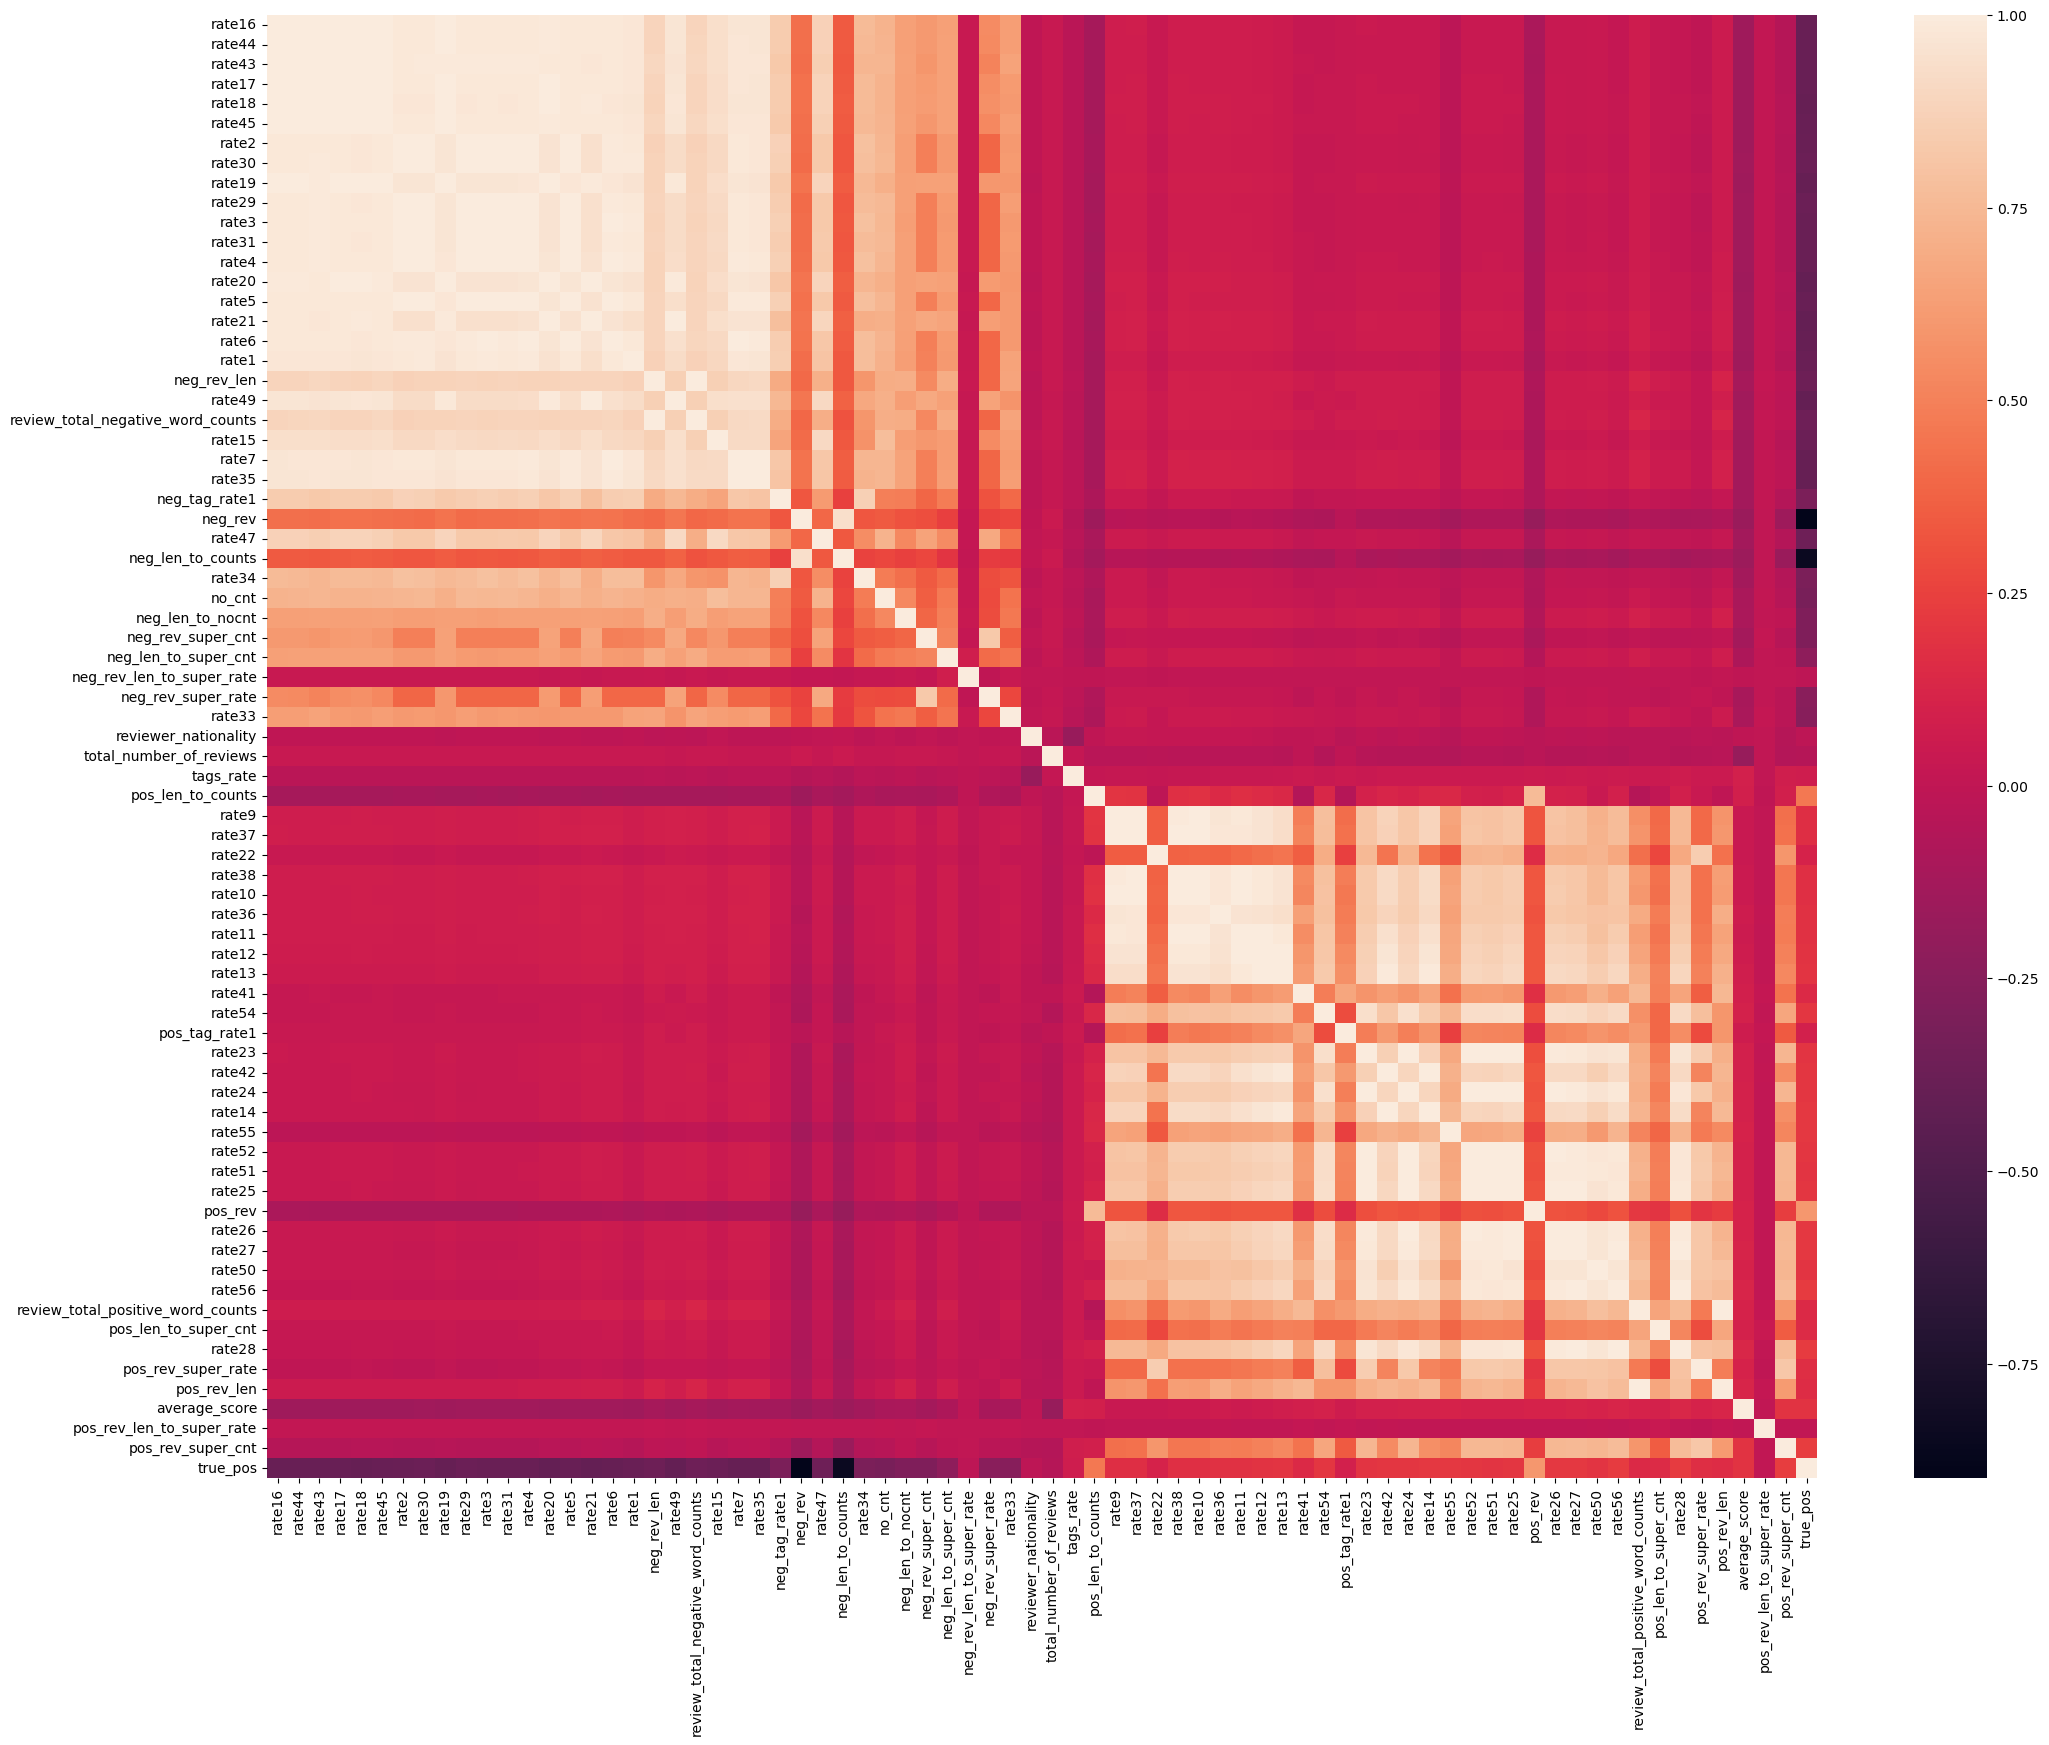

In [47]:
# визуализируем матрицу корреляции
f,a=plt.subplots(figsize=(25,19))
sns.heatmap(X.corr(numeric_only=True))

In [48]:
r_state = 42
t_size = 0.25

# разбиваем набор данных на "train" и "test".  
# для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=r_state)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 97), (384594, 97), (384594, 74), (288445, 74), (96149, 74))

In [49]:
%%time

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=r_state)  
      
# Обучаем модель на train наборе  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
y_pred = regr.predict(X_test)  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


CPU times: user 42min 38s, sys: 2.57 s, total: 42min 41s
Wall time: 10min 51s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [50]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) 
# Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений  
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', mape)

MAPE: 0.11620154424967341


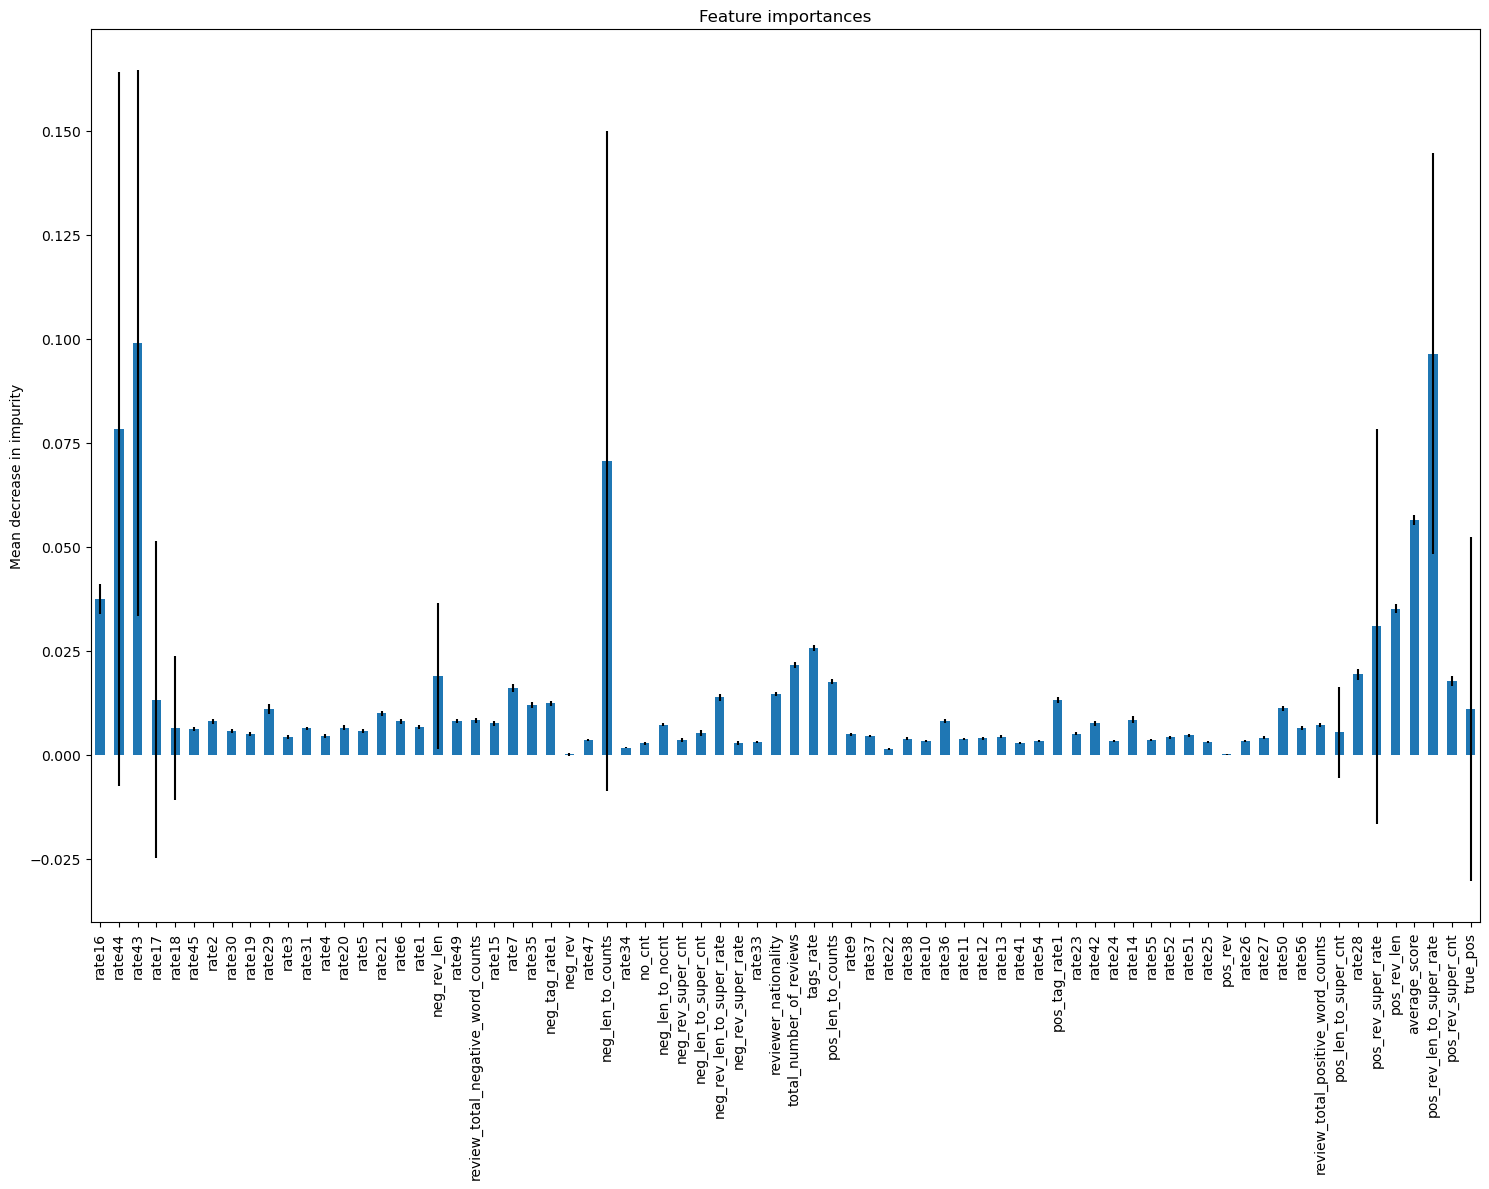

In [51]:
# оценим важность признаков
#start_time = time.time()
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
#elapsed_time = time.time() - start_time

forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=(15,12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<Axes: >

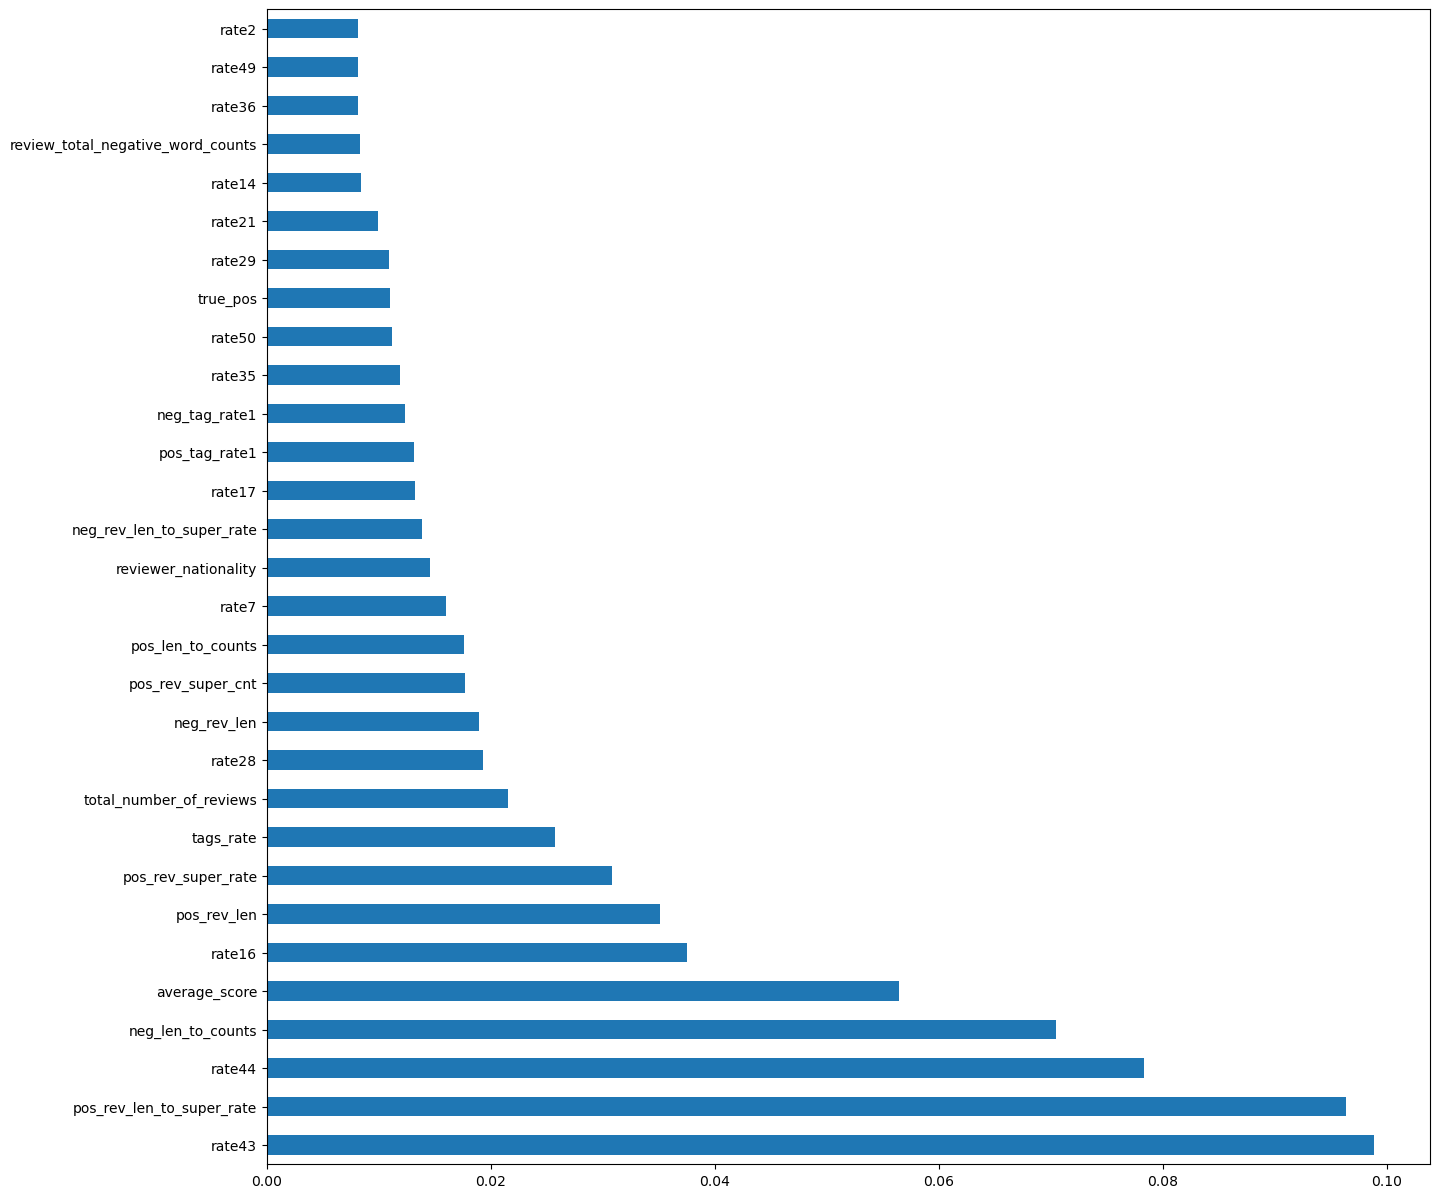

In [52]:
# отобразим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15,15)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [53]:
# готовим сабмит
test_data = test_data.loc[:, best_fea]
predict_submission = regr.predict(test_data)
test_data.loc[:,'reviewer_score'] = predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [54]:
submission['reviewer_score'] = test_data['reviewer_score']
submission.to_csv('submit.csv', index=False)
submission.head(10)

,reviewer_score,id
0,8.759,488440
1,8.007,274649
2,7.778,374688
3,9.960,404352
4,9.775,451596
5,8.437,302161
6,7.729,317079
7,8.194,13963
8,8.469,159785
9,7.275,195089
